In [1]:
"""Imports."""

import colorsys
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import lines as mlp_lines

import sys
sys.path.append('../../phys_analysis/sessions')
import recording_sessions


In [3]:
"""Constants."""

_DATA_DIR = (
    '/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/'
    'multi_prediction/datasets/data_open_source/Subjects'
)

_PHASE_COLORS = [
    ('stimulus on', colorsys.hsv_to_rgb(0.28, 1., 1.)),  # stimulus onset
    ('delay on', colorsys.hsv_to_rgb(0.4, 1., 1.)),  # delay onset
    ('cue on', colorsys.hsv_to_rgb(0.52, 1., 1.)),  # cue onset
    ('response', colorsys.hsv_to_rgb(0.64, 1., 1.)),  # response onset
    ('reveal on', colorsys.hsv_to_rgb(0.76, 1., 1.)),  # reveal onset
]

# How long (seconds) before stimulus onset to begin raster plot
_T_BEFORE_STIMULUS_ONSET = 0.5
# How long (seconds) after stimulus onset to end raster plot
_T_AFTER_STIMULUS_ONSET = 3.25

# Bootstrap number for PSTH
_PSTH_BOOTSTRAP_NUM = 100
# Bin width for PSTH
_PSTH_BIN_WIDTH = 0.03
# Number of bins in half the range of the tooth smoothing function for PSTHs
_PSTH_KERNEL_HALF_WIDTH = 5


In [12]:
"""Get data."""

_SUBJECT = 'monkey0'
_SESSION = '2022-04-28'

_PROBE = 'probe02'
_UNIT = 133
# _PROBE = 'probe01'
# _UNIT = 96
# _PROBE = 'probe00'
# _UNIT = 181

# Get session_dir and probe_dir
session_dir = os.path.join(_DATA_DIR, _SUBJECT, _SESSION, '001')
probe_dir = os.path.join(session_dir, _PROBE)

# Get start_times and relative_phase_times
start_times_path = os.path.join(
    session_dir, 'task', 'trials.start_times.json')
start_times = json.load(open(start_times_path, 'r'))
relative_phase_times_path = os.path.join(
    session_dir, 'task', 'trials.relative_phase_times.json')
relative_phase_times = json.load(open(relative_phase_times_path, 'r'))

# Load spike clusters and times
spikes_clusters = np.load(os.path.join(probe_dir, 'spikes.clusters.npy'))
spikes_times = np.load(os.path.join(probe_dir, 'spikes.times.npy'))
spike_times = spikes_times[np.argwhere(spikes_clusters == _UNIT)[:, 0]]

In [13]:
"""Raster plotting function."""

def _plot_raster(ax,
                 spike_times,
                 start_times,
                 relative_phase_times,
                 start_trial_index=0,
                 num_trials_to_plot=500):
    """Make raster plot."""
    spikes_raster_x = []
    spikes_raster_y = []

    phase_times_raster_x = []
    phase_times_raster_y = []
    phase_times_raster_colors = []

    spike_times_per_trial = []

    num_trials = len(start_times)
    spike_index = 0
    completed_trial_inds = []
    trial_count = 0
    for trial_num in range(start_trial_index, num_trials):
        start_t = start_times[trial_num]
        
        if not np.isfinite(start_t):
            spike_times_per_trial.append([])
            continue

        rel_phase_t = relative_phase_times[trial_num]
        if len(rel_phase_t) != 6:
            continue
        
        rel_visible_phase_t = rel_phase_t[0]
        stimulus_onset_t = start_t + rel_visible_phase_t

        # Append the relative phase times to raster data
        for i, t in enumerate(rel_phase_t):
            if i >= len(_PHASE_COLORS):
                break
            phase_times_raster_x.append(t - rel_visible_phase_t)
            phase_times_raster_y.append(trial_count)
            phase_times_raster_colors.append(_PHASE_COLORS[i][1])
            
        # Count spike times per completed trial if this trial has all phases
        completed_trial = len(rel_phase_t) == 6
        completed_trial_inds.append(completed_trial)
        spike_times_this_trial = []

        if trial_count > num_trials_to_plot:
            break
        
        # Update spikes raster data based on spike times
        next_trial = False
        while not next_trial:
            if spike_index >= len(spike_times):
                # No more spikes for this neuron, so move on to next trial
                next_trial = True
                continue
            
            spike_t = spike_times[spike_index]

            if spike_t > stimulus_onset_t + _T_AFTER_STIMULUS_ONSET:
                # Trial is completed, so move on to next trial
                next_trial = True
                continue
            
            if (trial_num < len(start_times) - 1 and
                    spike_t > start_times[trial_num + 1]):
                # Trial is completed, so move on to next trial
                next_trial = True
                continue

            if spike_t < stimulus_onset_t - _T_BEFORE_STIMULUS_ONSET:
                # Have yet to reach beginning of trial, so move on to next spike
                spike_index += 1
                continue

            # Append the spike time to raster data
            spikes_raster_x.append(spike_t - stimulus_onset_t)
            spikes_raster_y.append(trial_count)
            spike_index += 1

            # Append spike time to spike_times_this_trial if necessary
            if completed_trial:
                spike_times_this_trial.append(spike_t - stimulus_onset_t)
        
        # Append spike_times_this_trial to spike_times_per_trial
        spike_times_per_trial.append(spike_times_this_trial)
        trial_count += 1
    

    spike_times_per_comp_trial_start = [
        x for completed, x in zip(completed_trial_inds, spike_times_per_trial)
        if completed and len(x) > 0
    ]
    spike_times_per_comp_trial_end = [
        [s - rel_phase_t[3] for s in x]
        for completed, x in zip(completed_trial_inds, spike_times_per_trial)
        if completed and len(x) > 0
    ]

    # Scatter spike times and phases
    ax.scatter(spikes_raster_x, spikes_raster_y, c='k', s=0.2)
    ax.scatter(
        phase_times_raster_x, phase_times_raster_y, c=phase_times_raster_colors,
        s=0.2)

    # Create axis labels
    ax.set_xlabel('Time within trial (sec)', fontsize=10)
    ax.set_ylabel('Trial number', fontsize=12)
    ax.set_xlim(
        -0.1 - _T_BEFORE_STIMULUS_ONSET,
        0.2 + _T_AFTER_STIMULUS_ONSET,
    )
    ax.set_ylim(-10, num_trials_to_plot + 10)

    # Create legend
    legend_handles = [
        mlp_lines.Line2D(
            [], [], marker='.', color=color, markerfacecolor=color,
            markersize=3.5, label=label, linewidth=0.)
        for label, color in _PHASE_COLORS
    ]
    ax.legend(
        handles=legend_handles, loc='upper center', bbox_to_anchor=(0.45, 1.1),
        ncol=5, fancybox=True, markerscale=3, borderpad=0.,
        columnspacing=0.6, handletextpad=0., handlelength=1.5, fontsize=13,
    )

    return spike_times_per_comp_trial_start, spike_times_per_comp_trial_end


In [14]:
"""PSTH plotting function."""

def _times_to_hist(x, bin_edges, kernel):
    hist, _ = np.histogram(x, bin_edges)
    hist = np.convolve(hist, kernel, mode='same')

    # Remove edge effects from convolution
    end_pad = (len(kernel) - 1) // 2
    beginning_pad = len(kernel) - 1 - end_pad
    beginning_normalization = np.cumsum(kernel)[-beginning_pad - 1: -1]
    end_normalization = np.cumsum(kernel[::-1])[-end_pad - 1: -1][::-1]
    hist[:beginning_pad] /= beginning_normalization
    hist[-end_pad:] /= end_normalization
    
    return hist


def _bootstrap_psth(spike_hists_per_trial):
    all_psths = []
    num_trials = len(spike_hists_per_trial)
    sample_size = int(np.ceil(0.5 * num_trials))
    for _ in range(_PSTH_BOOTSTRAP_NUM):
        trial_inds = np.random.choice(
            num_trials, size=sample_size, replace=True)
        psth = np.mean(spike_hists_per_trial[trial_inds], axis=0)
        all_psths.append(psth)
    return np.array(all_psths)


def _plot_psth(ax, spike_times_per_completed_trial):
    """Plot PSTH."""
    if len(spike_times_per_completed_trial) == 0:
        return

    bin_edges = np.arange(
        -_T_BEFORE_STIMULUS_ONSET,
        _PSTH_BIN_WIDTH + _T_AFTER_STIMULUS_ONSET,
        _PSTH_BIN_WIDTH,
    )
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Get bootstrap PSTHs
    kernel = np.linspace(0., 1., _PSTH_KERNEL_HALF_WIDTH)
    kernel = np.concatenate([kernel, kernel[:-1][::1]])
    kernel /= np.sum(kernel)
    spike_hists_per_trial = np.array([
        _times_to_hist(x, bin_edges, kernel)
        for x in spike_times_per_completed_trial
    ])
    psths = _bootstrap_psth(spike_hists_per_trial)
    psths /= _PSTH_BIN_WIDTH  # Convert to units of seconds
    
    # Create dataframe with PSTHs
    data_df_dict = {
        'Time within trial (s)': np.tile(bin_centers, psths.shape[0]),
        'Firing rate (Hz)': np.ravel(psths),
    }
    data_df = pd.DataFrame(data_df_dict)

    # Plot PSTH
    sns.lineplot(
        ax=ax, data=data_df, x='Time within trial (s)', y='Firing rate (Hz)',
        color=[0.9, 0.1, 0.1], errorbar='sd', linewidth=3,
    )

    # Axis handling
    ax.set_xlim(
        -0.1 - _T_BEFORE_STIMULUS_ONSET,
        0.1 + _T_AFTER_STIMULUS_ONSET,
    )
    ax.axvline(x=0., linewidth=1., color=_PHASE_COLORS[0][1])
    ax.axvline(x=1., linewidth=1., color=_PHASE_COLORS[1][1])

    return

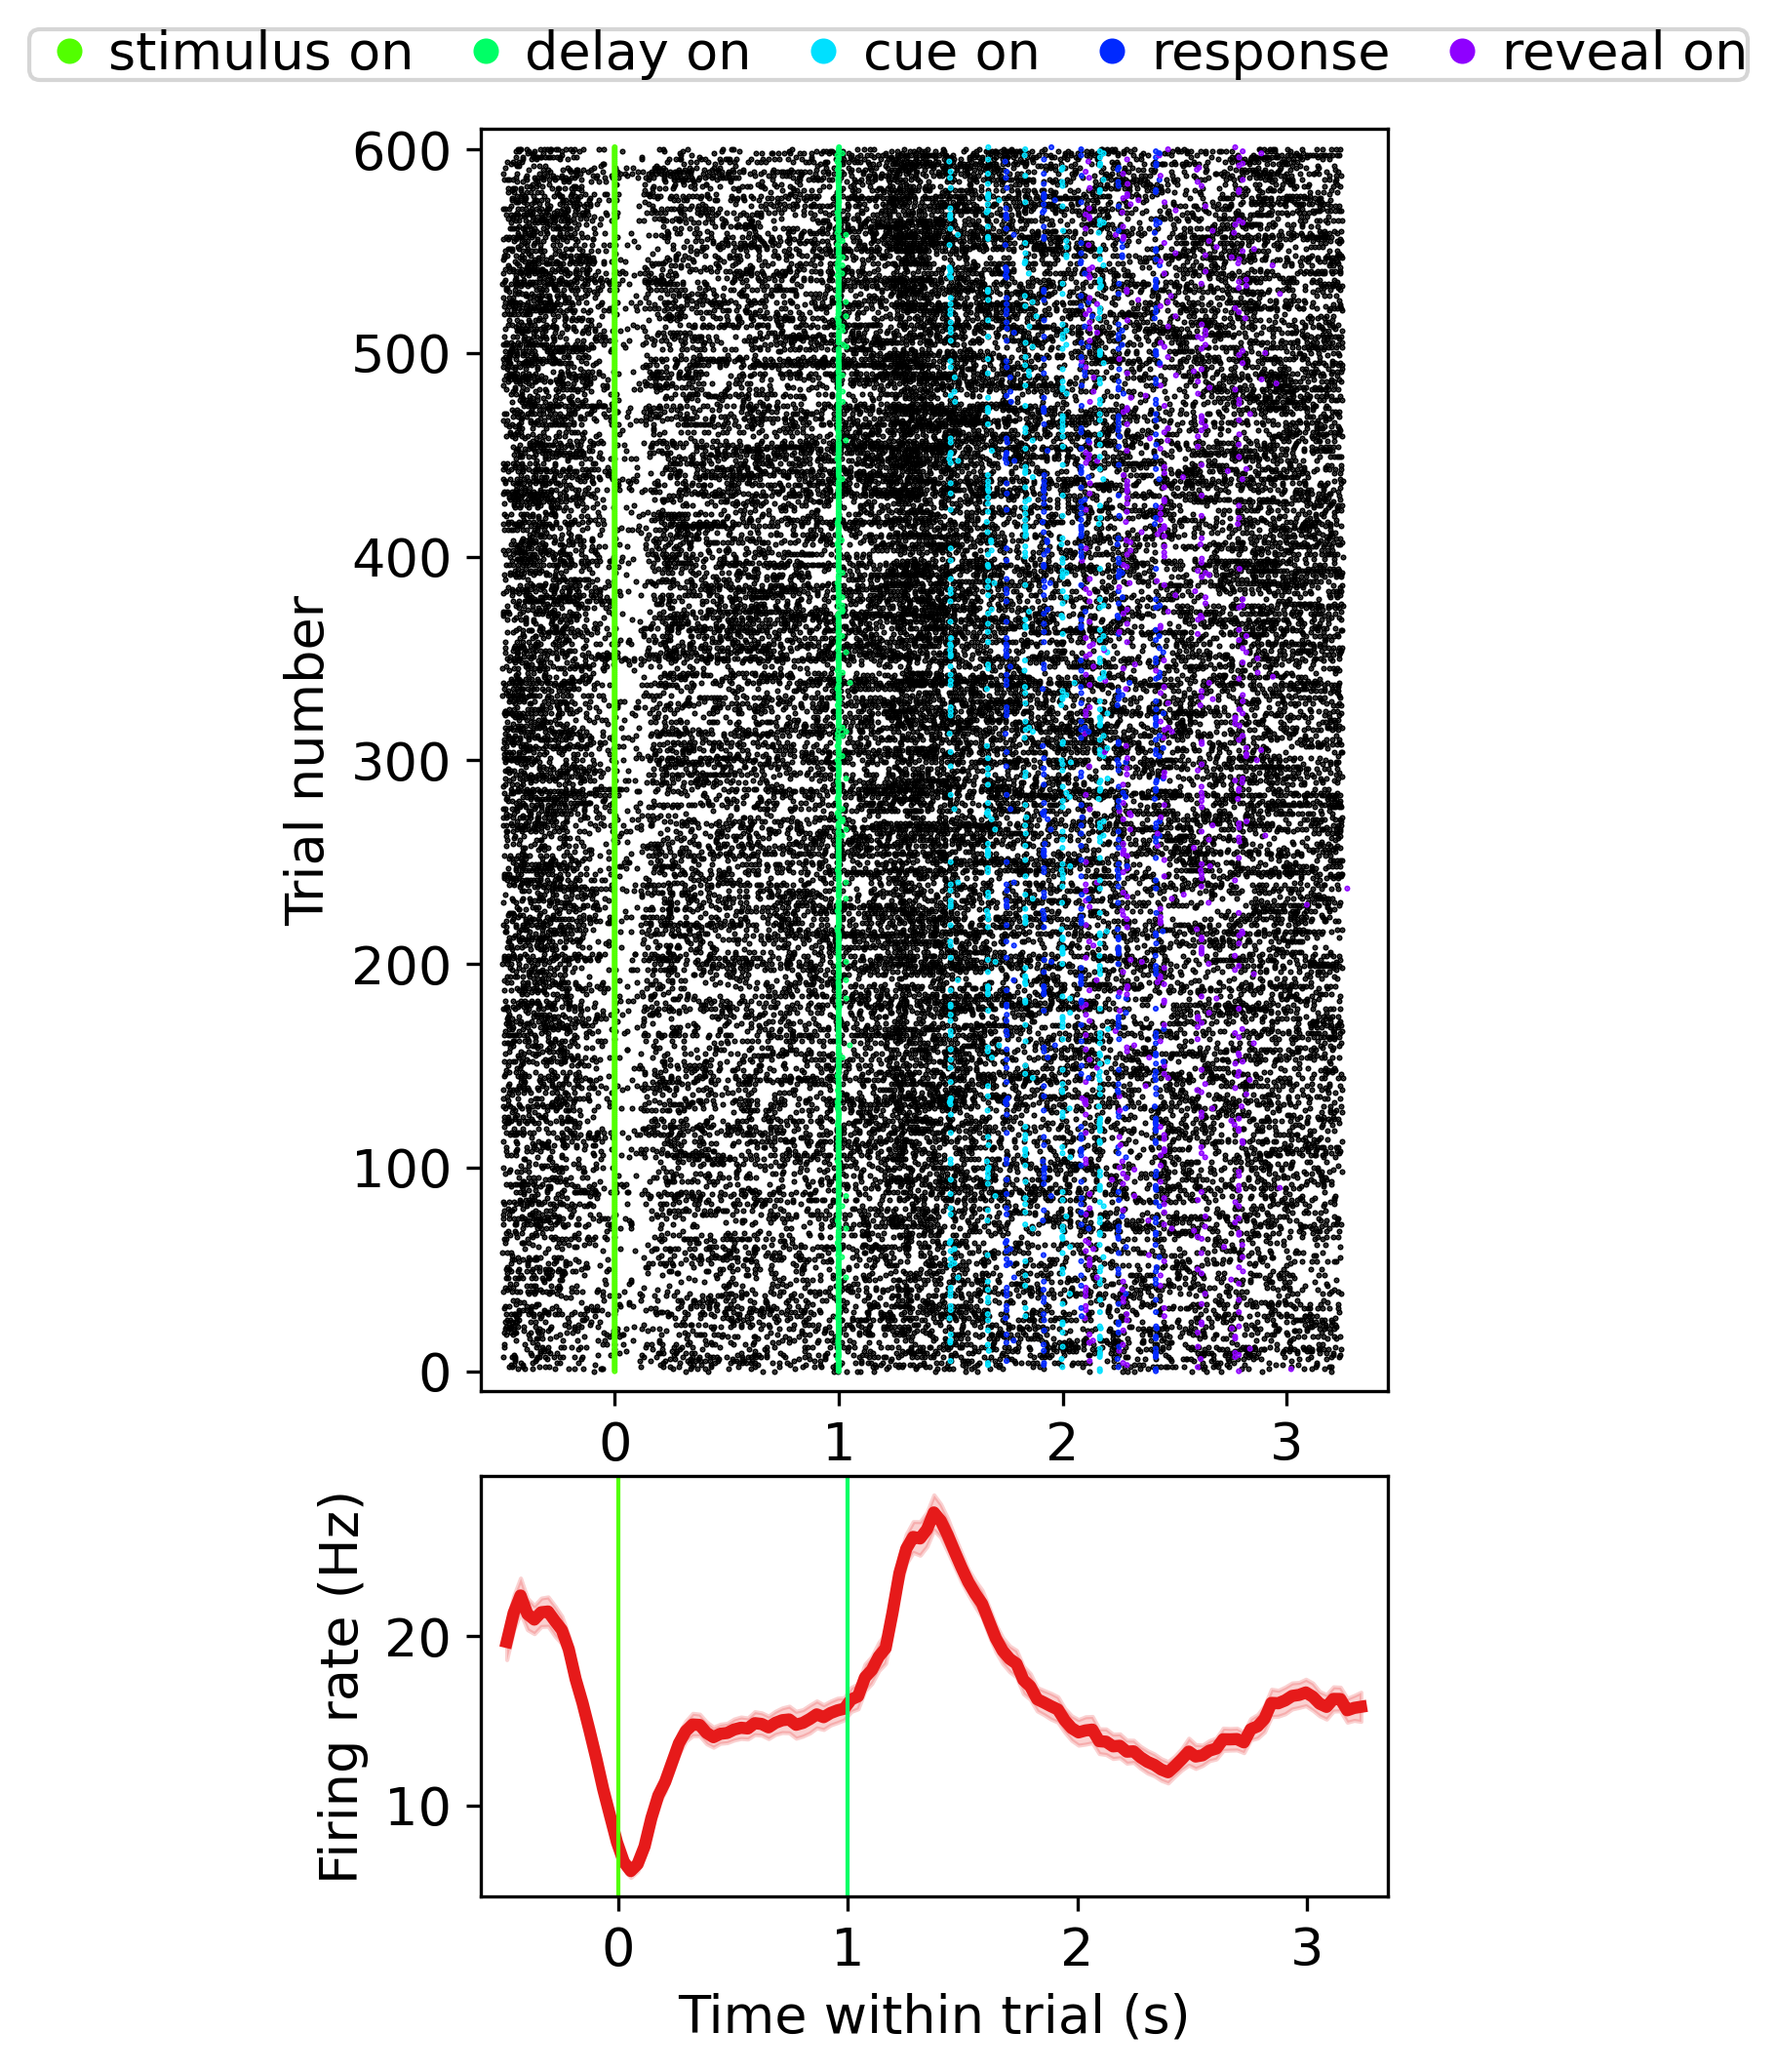

In [15]:
"""Make plot."""

# Create figure and axes
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(4, 8), gridspec_kw=dict(height_ratios=(3, 1)),
)

# Plot raster and psth
spike_times_per_comp_trial_start, spike_times_per_comp_trial_end = _plot_raster(
    ax_raster, spike_times, start_times, relative_phase_times,
    start_trial_index=400, num_trials_to_plot=600)
_plot_psth(ax_psth, spike_times_per_comp_trial_start)

ax_raster.yaxis.set_tick_params(labelsize=13)
ax_raster.xaxis.set_tick_params(labelsize=13)
ax_raster.set_xlabel('')
ax_raster.set_ylabel('Trial number', fontsize=13)
ax_psth.yaxis.set_tick_params(labelsize=13)
ax_psth.xaxis.set_tick_params(labelsize=13)
ax_psth.set_xlabel('Time within trial (s)', fontsize=13)
ax_psth.set_ylabel('Firing rate (Hz)', fontsize=13)

plt.subplots_adjust(hspace=0.1)